just to follow up on our chat, here is what I think we should do to make new snapshot files:
- my simulation snapshots are on bridges at /ocean/projects/ast190007p/plaplant/ksz/long/jordan_bias/output_00??. in each of those folders, there is a file called obs_grids.hdf5, which has the 21cm brightness temperature, and pk_arrays.hdf5, which has the ionization history
- for each of those realizations, I recommend grabbing 50-100 slices from the most “interesting” parts of the ionization history. probably something in the range 6 <= z <= 12
- I will give you a mapping between the line-of-sight index and the redshift. the data are in the obs_grids.hdf5 file at a dataset called data/t21_box. it’s a dataset of size (698, 1024, 1024)
- grab a slice at a particular index, say, 101. you’d do something like h5f["data/t21_box"][101, :, :]. if you want to further trim this down so it’s not 1024 x 1024, feel free to do that
- using the mapping for redshift index, you’d find the redshift that 101 corresponds to (let’s say it’s 7.23), and then interpolate based on the ionization history. the data for this interpolation is in the pk_arrays.hdf5 file, at the datasets data/zval_list (for the redshifts) and data/xval_list (for the neutral fractions)
- in your own snapshot file, you would add the 21cm slice to your “snapshot” array, and the neutral fraction/ionization fraction to your “snapshot labels” array
- then you use these files to train the best neural network ever :sunglasses:

1. build function that selects 100 images (every 6th image I think) from each of the 30 boxes (in this case I only have 1 box from "output_0001").
    - the starting index will be a variable
    - gap between start index and next needs to always be 6
2. build an empty data container (maybe another hdf5 file) and place the selected data in there and save to disk (overwrite if need be).
3. crop the image into something small like 64x64 in the center of the 1024x1024 image and save to disk (overwrite if need be).

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras_tuner as kt, tensorflow as tf
import os, datetime, progressbar, h5py
import tensorflow_probability as tfp

tfd = tfp.distributions

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint#, TensorBoard                                                                      
from keras import backend as K
from livelossplot import PlotLossesKeras

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hypermodel import HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
#from tensorboard.plugins.hparams import api as hp                                                                             
#from keras.utils.generic_utils import get_custom_objects                                                                      

import gc
gc.enable()

hp = HyperParameters()
plotlosses = PlotLossesKeras()

In [ ]:
# You can combine arrays of different sizes together
a_0 = np.random.normal(0,1,size=(3,4,5,))
a_1 = np.random.normal(0,1,size=(4,5,6,))
a_2 = np.random.normal(0,1,size=(35,19,97,))
a_3 = np.random.normal(0,1,size=(2,6,14,22,89))
A_concate = np.array([a_0, a_1, a_2, a_3], dtype=object)

In [2]:
CROP_LENGTH = 128

f = h5py.File('t21_snapshots_nowedge_v9.hdf5', 'r')
X_train = f['Data']['t21_snapshots']
y_train = f['Data']['snapshot_labels'][:,5]

X_test = X_train[800:]
y_test = y_train[800:]

print("training", X_train.shape)
print("validation", X_test.shape)

training (1000, 30, 512, 512)
validation (200, 30, 512, 512)


In [ ]:
np.transpose(X_test, axes=[0, 2, 3, 1]).shape

In [3]:
# Crop the imagees for training and test image 
# /ocean/projects/ast180004p/tbilling/scripts/utilities.py 

def crop(image, img_height, img_width, crop_length):

    start_y = (img_height - crop_length) // 2
    start_x = (img_width - crop_length) // 2
    cropped_image=image[:, :, start_x:(img_width - start_x), start_y:(img_height - start_y)]

    return cropped_image

x_crop = np.transpose(crop(X_train[:640], img_height=X_train.shape[2], img_width=X_train.shape[2], crop_length=CROP_LENGTH)
                      , axes=[0, 2, 3, 1])
y_crop = y_train[:640]
val_x_crop = np.transpose(crop(X_train[640:800], img_height=X_train.shape[2], img_width=X_train.shape[2], 
                  crop_length=CROP_LENGTH), axes=[0, 2, 3, 1])
val_y_crop = y_train[640:800]

x_test_crop = np.transpose(crop(X_test, img_height=X_test.shape[2], img_width=X_test.shape[2], crop_length=CROP_LENGTH)
                           , axes=[0, 2, 3, 1])
y_test_crop = y_test

In [4]:
outputdir = "./"
project_name='zreion_{}_model_tuner'.format(CROP_LENGTH)

HP_EPOCH = 30
HP_BATCH_SIZE = 5
factor = 100
num_models = 25

In [5]:
NUM_TRAIN_EXAMPLES = len(x_crop)
kl_divergence_function = (
lambda q, p, _: tfd.kl_divergence(q, p) / tf.cast(NUM_TRAIN_EXAMPLES,dtype=tf.float32)
)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


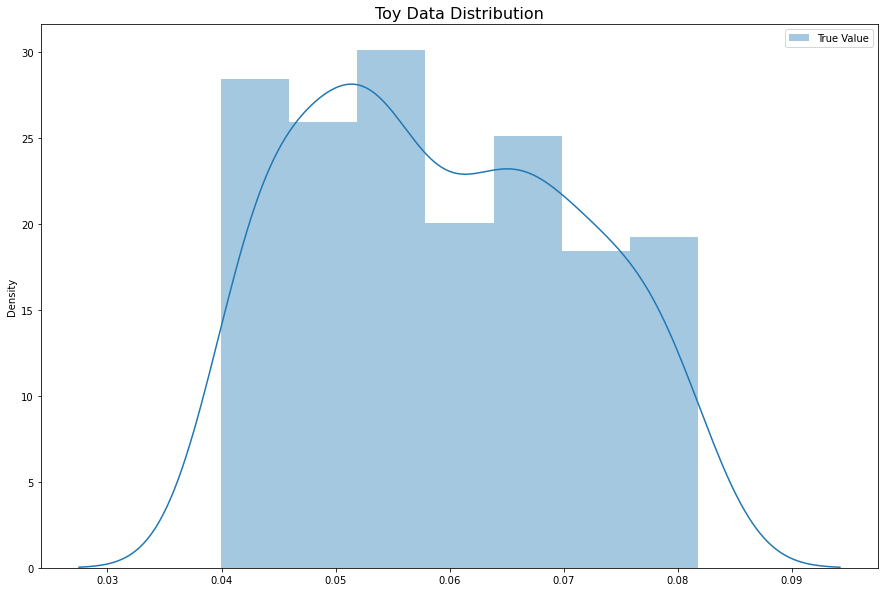

In [6]:
plt.figure(figsize=(15, 10))
sns.distplot(y_test,label="True Value")
plt.title("Toy Data Distribution",size = 16 )
#plt.xlim([0, 1.25])
plt.legend()

In [7]:
x_crop.shape

(640, 128, 128, 30)

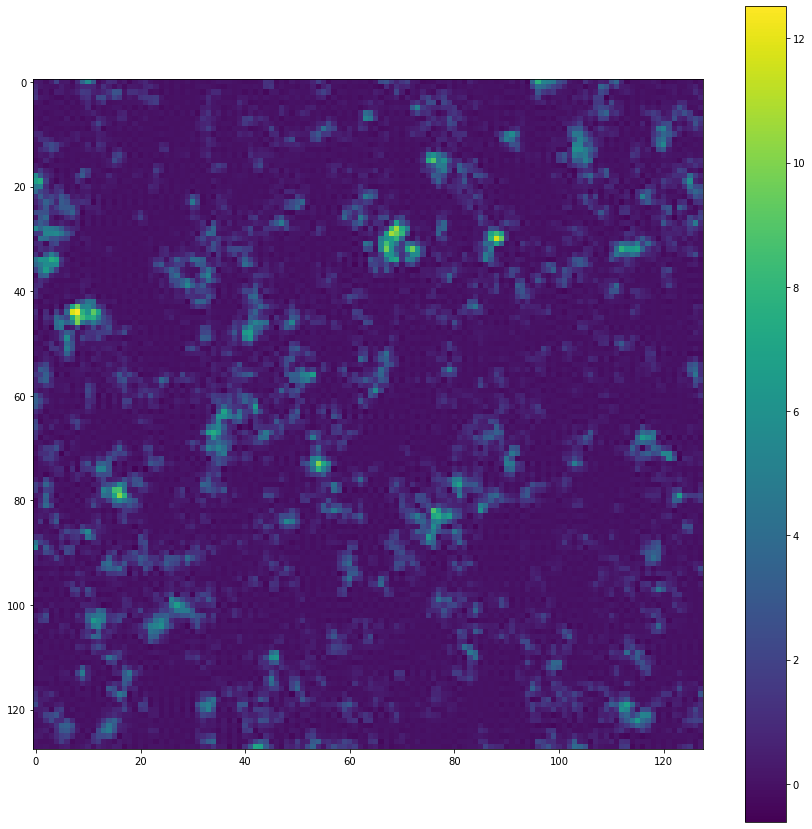

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(x_test_crop[0,:,:, 0])
plt.colorbar()

In [ ]:
with h5py.File('data.hdf5', 'w') as hf:
    hf.create_dataset("x_train", data=x_crop)
    hf.create_dataset("y_train", data=y_train[:640])
    hf.create_dataset("val_x_train", data=val_x_crop)
    hf.create_dataset("val_y_train", data=y_train[640:800])
    hf.create_dataset("x_test", data=X_train[800:])
    hf.create_dataset("y_test", data=y_train[800:])

In [9]:
ls -lrt

total 99771056
drwxr-xr-x@  3 tashaleebillings  staff           96 Jan 25 17:37 make_plots/
-rw-r--r--@  1 tashaleebillings  staff          660 Jan 26 08:49 bash_script.sh
-rw-r--r--@  1 tashaleebillings  staff          990 Jan 26 21:35 nrao_bash_script.sh
-rw-r--r--@  1 tashaleebillings  staff          756 Jan 29 14:20 brdges2_bash_script.sh
drwxr-xr-x@ 24 tashaleebillings  staff          768 Feb 14 12:07 GenLightBatches/
-rw-r--r--@  1 tashaleebillings  staff        12082 Feb 22 12:27 train_cnn_determ_loss_dropout_model.py
-rw-r--r--@  1 tashaleebillings  staff        13363 Feb 22 12:27 train_cnn_determ_loss_flipout_model.py
-rw-r--r--@  1 tashaleebillings  staff        10561 Feb 22 12:27 train_cnn_prob_loss_flipout_model.py
-rw-r--r--@  1 tashaleebillings  staff        29767 Feb 22 12:50 train_cnn.py
-rw-r--r--@  1 tashaleebillings  staff        10323 Mar 14 06:42 train_cnn_oldarch_model.py
-rw-r--r--@  1 tashaleebillings  staff        55022 Mar 15 15:30 model_functions.py
-rw-r--r-

In [ ]:
cf = h5py.File('data.h5', 'r')
cf.keys()

In [ ]:
cf['val_x_train']

In [10]:
# Custom Loss Functions                                                                                                               
kl_divergence = tf.keras.losses.KLDivergence()

neg_log_likelihood = lambda y_true, y_pred: -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))

def Mean_Squared_over_true_Error(y_true, y_pred):
    # Create a custom loss function that divides the difference by the true                                                           

    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.                                        
    diff_ratio = K.square((y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None))

    loss = K.mean(diff_ratio, axis=-1)

    # Return a tensor                                                                                                                 
    return loss

def elbo(y_true, y_pred):
    kl_weight = 1
    neg_log_likelihood = -tf.reduce_mean(input_tensor=y_pred.log_prob(y_true))
    kl_divergence = tf.keras.losses.KLDivergence()

    elbo_loss = -tf.math.reduce_mean(-kl_weight * kl_divergence(y_true, y_pred.mean()) - neg_log_likelihood)
    # Return a tensor                                                                                                                 
    return elbo_loss

def mean_fractional_error(y_true, y_pred):
    y_true = K.cast(y_true, y_pred.dtype) #Casts a tensor to a different dtype and returns it.
    diff_ratio = (y_pred - y_true)/K.clip(K.abs(y_true),K.epsilon(),None)
    loss = K.mean(diff_ratio, axis=-1)
    
    return loss

keras.utils.get_custom_objects().update({'Mean_Squared_over_true_Error':Mean_Squared_over_true_Error,
                                        'neg_log_likelihood': neg_log_likelihood, 'kl_divergence':kl_divergence,
                                        'elbo':elbo})
    

LEARN STD and MEAN

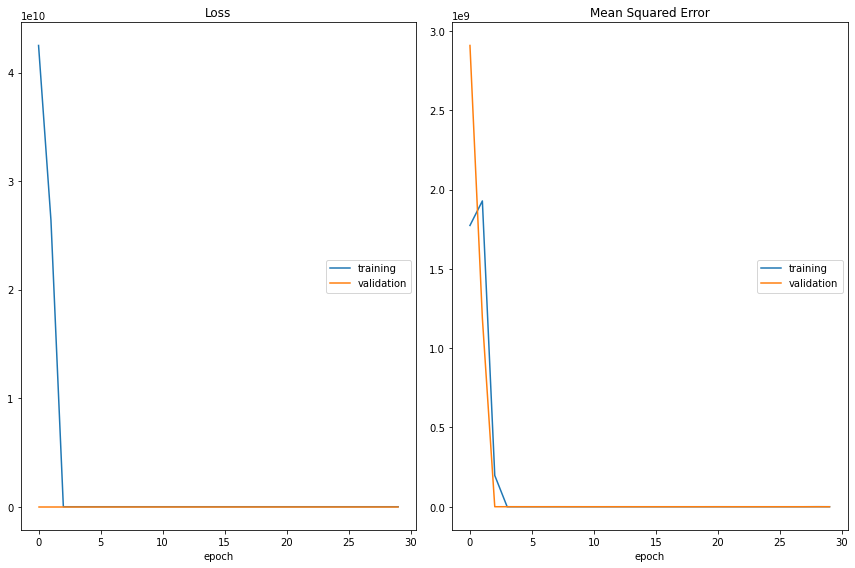

Loss
	training         	 (min:  504.864, max: 42500444160.000, cur:  512.644)
	validation       	 (min:  504.818, max: 5513.511, cur:  504.818)
Mean Squared Error
	training         	 (min:    0.445, max: 1929129216.000, cur: 27261.016)
	validation       	 (min:    0.377, max: 2909839104.000, cur:    0.463)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 126, 126, 16)      8656      
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 124, 124, 8)       2312      
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 1)                 246017    
_________________________________________________________________
distribution

In [11]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(CROP_LENGTH, CROP_LENGTH, 30), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    model.add(Flatten())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(x_crop, y_crop, validation_data=(val_x_crop, val_y_crop),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(x_test_crop, y_test_crop)
    return model
                                                                                                                                                                                      
model = train_test_model()



In [12]:
# make predictions                                                                                                                                                                      
predictions = []
for i in range(50):
    y_p = model.predict(x_test_crop).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)
    

(200, 128, 128, 30)
(200,)
(200,)


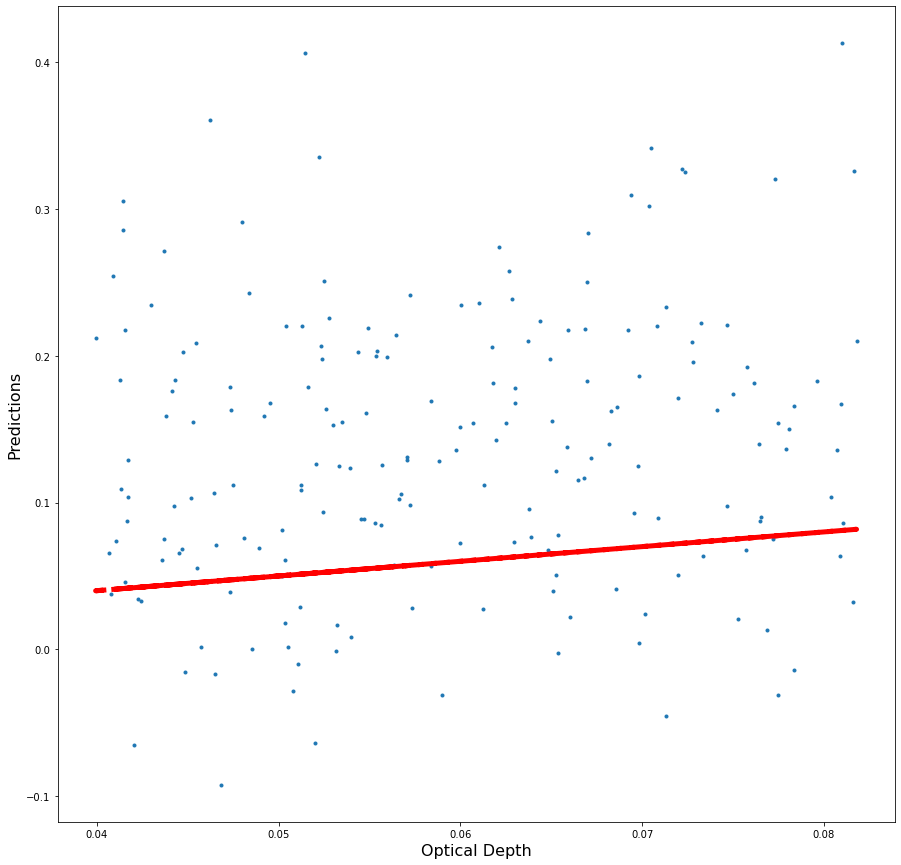

In [16]:
prediction = np.mean(np.array(predictions), axis=0)
print(x_test_crop.shape)
print(prediction.shape)
print(y_test_crop.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Optical Depth", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test_crop, prediction, '.')
plt.plot(y_test_crop,y_test_crop, "r--", linewidth=5)

In [14]:
val_y_crop.shape

(160,)

/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tashaleebillings/anaconda3/envs/hp_opt/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

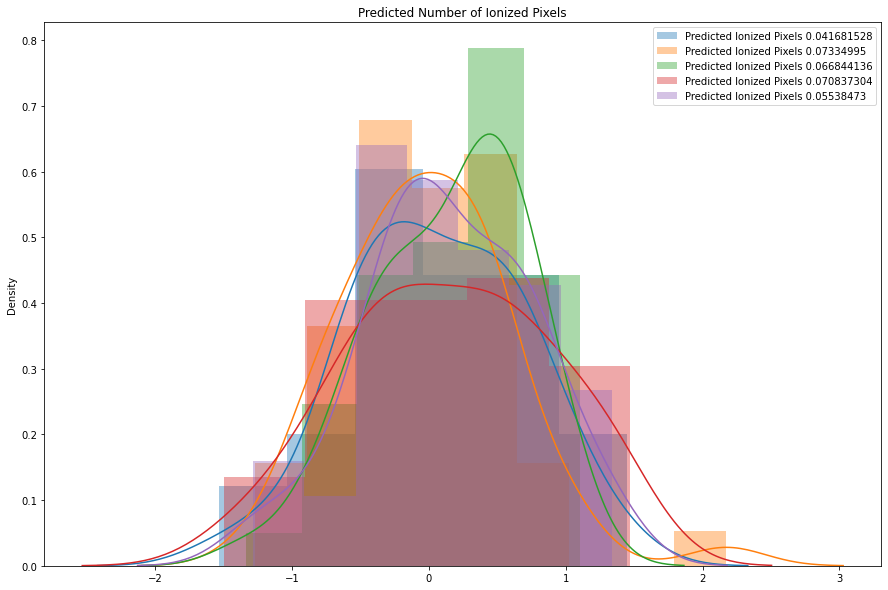

In [15]:
plt.figure(figsize=(15, 10))
plt.title("Predicted Number of Ionized {}".format("Pixels",size = 16 ))

sns.distplot(np.array(predictions)[:,0]-y_test_crop[0],label="Predicted Ionized Pixels {}".format(str(y_test_crop[0])))
sns.distplot(np.array(predictions)[:,1]-y_test_crop[1],label="Predicted Ionized Pixels {}".format(str(y_test_crop[1])))
sns.distplot(np.array(predictions)[:,2]-y_test_crop[2],label="Predicted Ionized Pixels {}".format(str(y_test_crop[2])))
sns.distplot(np.array(predictions)[:,3]-y_test_crop[3],label="Predicted Ionized Pixels {}".format(str(y_test_crop[3])))
sns.distplot(np.array(predictions)[:,4]-y_test_crop[4],label="Predicted Ionized Pixels {}".format(str(y_test_crop[4])))

#plt.xlim([0, 1.25])
plt.legend(markerscale=2.5)


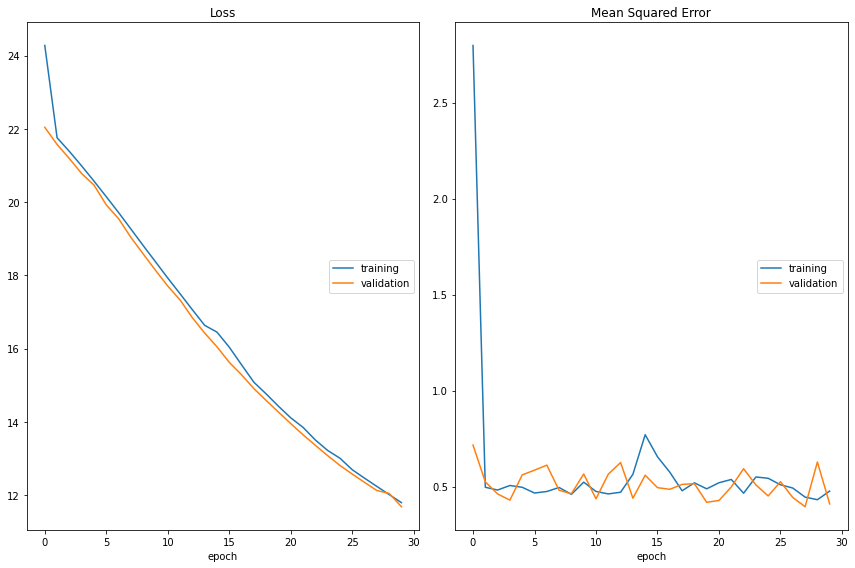

Loss
	training         	 (min:   11.790, max:   24.277, cur:   11.790)
	validation       	 (min:   11.679, max:   22.041, cur:   11.679)
Mean Squared Error
	training         	 (min:    0.431, max:    2.798, cur:    0.476)
	validation       	 (min:    0.395, max:    0.716, cur:    0.409)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_9 (Conv2DFlip (None, 126, 126, 16)      8656      
_________________________________________________________________
conv2d_flipout_10 (Conv2DFli (None, 124, 124, 8)       2312      
_________________________________________________________________
global_average_pooling2d (Gl (None, 8)                 0         
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 1)                 17        
_________________________________________________________________
distribution_lambda_4 (Distr m

In [22]:
def train_test_model():
    # Making a model.                                                                                                                                                                       
    model = Sequential()
    
    model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
                                              input_shape=(CROP_LENGTH, CROP_LENGTH, 30), kernel_divergence_fn=kl_divergence_function,
                                              kernel_size=3, activation = 'relu'
                                              #, padding = 'same'
                                             ))
    #model.add(tfp.layers.Convolution2DFlipout(filters = 16, 
    #                                          kernel_size=3, activation = 'relu', 
    #                                          kernel_divergence_fn=kl_divergence_function,
    #                                          #padding = 'same'
    #                                         ))
    model.add(tfp.layers.Convolution2DFlipout(filters = 8, 
                                              kernel_size=3, activation = 'relu', 
                                              kernel_divergence_fn=kl_divergence_function,
                                              #padding = 'same'
                                             ))
    #model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(tfp.layers.DenseFlipout(1, activation="linear", kernel_divergence_fn=kl_divergence_function,))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           #scale = 1)))
                           scale=1e-3 + tf.math.softplus(0.01 * t[..., :1]))))
    

    model.compile(optimizer= "adam", loss = "neg_log_likelihood", metrics=["mse"])
    
    plotlosses = PlotLossesKeras()

    model.fit(x_crop, y_crop, validation_data=(val_x_crop, val_y_crop),
            epochs=HP_EPOCH, batch_size=HP_BATCH_SIZE,
            callbacks=[plotlosses],
            verbose=1)
    
    # Visualize Model                                                                                                                                                                      
    print(model.summary())

    loss = model.evaluate(x_test_crop, y_test_crop)
    return model
                                                                                                                                                                                      
model = train_test_model()



(200, 128, 128, 30)
(200,)
(200,)


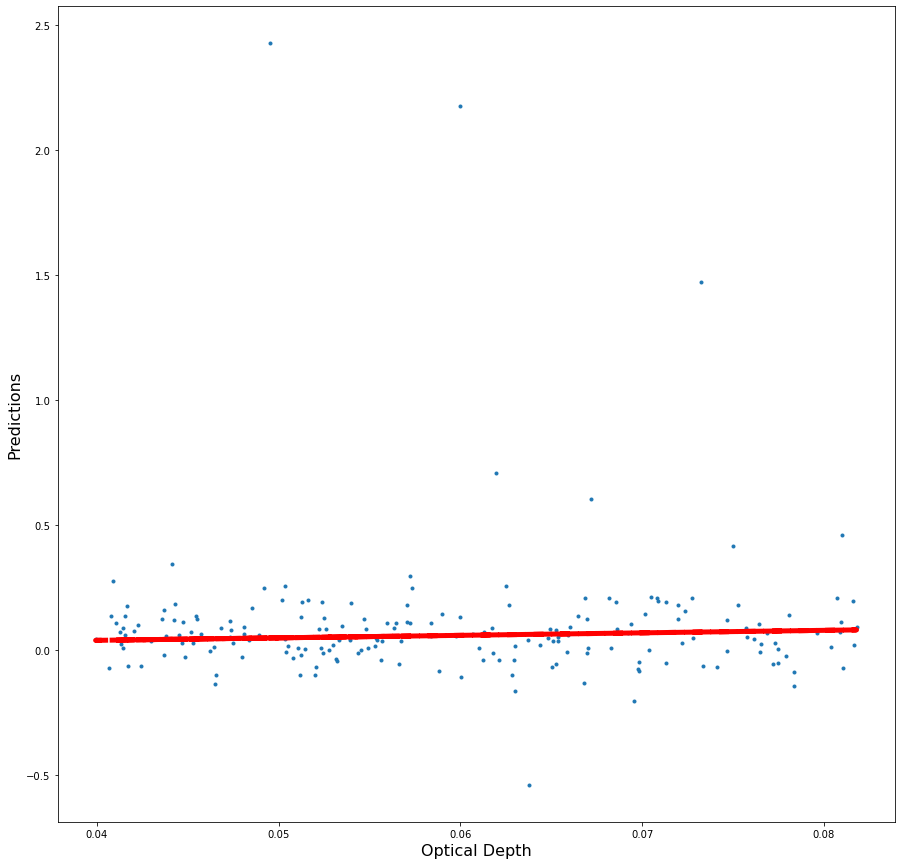

In [23]:
# make predictions                                                                                                                                                                      
predictions = []
for i in range(50):
    y_p = model.predict(x_test_crop).squeeze()#predict(X_test, batch_size=test_labels.shape[0])                                                                                              
    predictions.append(y_p) # (500, 100, 1) = (# of masks, # of datasets, # of classes)
    
prediction = np.mean(np.array(predictions), axis=0)
print(x_test_crop.shape)
print(prediction.shape)
print(y_test_crop.shape)

# Plot one-to-one predictions
plt.figure(figsize=(15,15))
plt.title("")
plt.xlabel("Optical Depth", size = 16)
plt.ylabel("Predictions", size = 16)
plt.plot(y_test_crop, prediction, '.')
plt.plot(y_test_crop,y_test_crop, "r--", linewidth=5)